#Beer Recommandations 
In this notebook I'll give beers recommendations using Collaborative filtering approach.
In particular I'll create Alternating Least of Squares model using pyspark and Single Vaulue Decomposition by Surprise.
I built to different  collaborative filtering approach in order to compare them.




In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install pyspark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

#Load dataset

In [ ]:
spark = SparkSession.builder.appName("Raccomandation").getOrCreate()
data = spark.read.csv("/content/drive/MyDrive/UNIVERSITA/BIG DATA/BIG DATA /beer_reviews.csv",inferSchema= True,header = True)

In [ ]:
data.show()

+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+--------------------+--------+-----------+
|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|          beer_style|review_palate|review_taste|           beer_name|beer_abv|beer_beerid|
+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+--------------------+--------+-----------+
|     10325|     Vecchio Birraio| 1234817823|           1.5|         2.0|              2.5|           stcules|          Hefeweizen|          1.5|         1.5|        Sausa Weizen|     5.0|      47986|
|     10325|     Vecchio Birraio| 1235915097|           3.0|         2.5|              3.0|           stcules|  English Strong Ale|          3.0|         3.0|            Red Moon|     6.2|      48

Select relevant features

In [ ]:
data_features = data.select("review_profilename","beer_beerid","review_overall","beer_style","brewery_id","beer_name")

In [ ]:
data_features.show()

+------------------+-----------+--------------+--------------------+----------+--------------------+
|review_profilename|beer_beerid|review_overall|          beer_style|brewery_id|           beer_name|
+------------------+-----------+--------------+--------------------+----------+--------------------+
|           stcules|      47986|           1.5|          Hefeweizen|     10325|        Sausa Weizen|
|           stcules|      48213|           3.0|  English Strong Ale|     10325|            Red Moon|
|           stcules|      48215|           3.0|Foreign / Export ...|     10325|Black Horse Black...|
|           stcules|      47969|           3.0|     German Pilsener|     10325|          Sausa Pils|
|    johnmichaelsen|      64883|           4.0|American Double /...|      1075|       Cauldron DIPA|
|           oline73|      52159|           3.0|Herbed / Spiced Beer|      1075| Caldera Ginger Beer|
|         Reidrover|      52159|           3.5|Herbed / Spiced Beer|      1075| Caldera Gin

In [ ]:
data_features.describe().show()

+-------+--------------------+-----------------+------------------+----------+------------------+------------------------+
|summary|  review_profilename|      beer_beerid|    review_overall|beer_style|        brewery_id|               beer_name|
+-------+--------------------+-----------------+------------------+----------+------------------+------------------------+
|  count|             1586266|          1586614|           1586614|   1586614|           1586614|                 1586614|
|   mean|4.8875126087603307E8|21712.79427888573|3.8155808533140387|      null|3130.0992018222455|       2684.936936936937|
| stddev| 5.370061777898421E9|21818.33599666985| 0.720621868051718|      null| 5578.103987474297|      12877.219938886066|
|    min|            0110x011|                3|               0.0|   Altbier|                 1|             ! (Old Ale)|
|    max|            zzajjber|            77317|               5.0|   Witbier|             28003|葉山ビール (Hayama Beer)|
+-------+------------

#Most common rate

#Preprocessing


Check any missing values 

In [ ]:
print(data_features.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_features.columns]).show())

+------------------+-----------+--------------+----------+----------+---------+
|review_profilename|beer_beerid|review_overall|beer_style|brewery_id|beer_name|
+------------------+-----------+--------------+----------+----------+---------+
|               348|          0|             0|         0|         0|        0|
+------------------+-----------+--------------+----------+----------+---------+

None


##Drop Null rows in dataset

In [ ]:
preprocessing_data = data_features.na.drop()



Percentage of NA values 

In [ ]:
diff = data_features.count()- preprocessing_data.count() 
print ("percentage of na values are : " +str(float((diff/(data_features.count())))) +""+"%")

percentage of na values are : 0.00021933501154029902%


In [ ]:
distinct_profilename  = data_features.select("review_profilename").distinct().count()
distinct_beerid = data_features.select("beer_beerid").distinct().count()
print(distinct_beerid)
print(distinct_profilename)


66055
33388


##Drop duplicates
* Percentage of duplicates
* dropping rows duplicated

In [ ]:
dropDisDF = preprocessing_data.dropDuplicates(["review_profilename","beer_beerid"])
print("Distinct count of users who rates a beer  : "+str(dropDisDF.count()))



Distinct count of users who rates a beer  : 1571480


In [ ]:
print( "percentage of duplicated is equal to " + str(((preprocessing_data.count()-dropDisDF.count())/preprocessing_data.count()))+ "%")

percentage of duplicated is equal to 0.00932126137734781%


In [ ]:
preprocessing_data = dropDisDF 

##change columns_profilename with profilenameid & changes the name 

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="review_profilename", outputCol="customer_id").fit(preprocessing_data)
full_data = indexer.transform(preprocessing_data)

In [ ]:
full_data.show()

+------------------+-----------+--------------+--------------------+----------+--------------------+-----------+
|review_profilename|beer_beerid|review_overall|          beer_style|brewery_id|           beer_name|customer_id|
+------------------+-----------+--------------+--------------------+----------+--------------------+-----------+
|          0110x011|        459|           4.5| American Strong Ale|       173|                Fred|     2476.0|
|          0110x011|        599|           4.0|      Lambic - Fruit|       187| Lindemans Framboise|     2476.0|
|          0110x011|        731|           5.0|          Hefeweizen|       252|Weihenstephaner H...|     2476.0|
|          0110x011|       1093|           4.0|        American IPA|       287|     Two Hearted Ale|     2476.0|
|          0110x011|       1160|           4.0|Russian Imperial ...|       147|Stone Imperial Ru...|     2476.0|
|          0110x011|       1444|           4.0|Russian Imperial ...|       287|Bell's Expedition

In [ ]:
full_data = full_data.withColumnRenamed("beer_beerid","beer_id")
full_data = full_data.withColumnRenamed("review_overall","rewiew")
full_data.show()

+------------------+-------+------+--------------------+----------+--------------------+-----------+
|review_profilename|beer_id|rewiew|          beer_style|brewery_id|           beer_name|customer_id|
+------------------+-------+------+--------------------+----------+--------------------+-----------+
|          0110x011|    459|   4.5| American Strong Ale|       173|                Fred|     2476.0|
|          0110x011|    599|   4.0|      Lambic - Fruit|       187| Lindemans Framboise|     2476.0|
|          0110x011|    731|   5.0|          Hefeweizen|       252|Weihenstephaner H...|     2476.0|
|          0110x011|   1093|   4.0|        American IPA|       287|     Two Hearted Ale|     2476.0|
|          0110x011|   1160|   4.0|Russian Imperial ...|       147|Stone Imperial Ru...|     2476.0|
|          0110x011|   1444|   4.0|Russian Imperial ...|       287|Bell's Expedition...|     2476.0|
|          0110x011|   1577|   4.0|Fruit / Vegetable...|       590|Wisconsin Belgian...|   

##Dataset Sparsity 
This snippet is useful to compute the data sparsity of dataset
* Count the number of distinct user_ids and distinct beer_ids

* Set the denominator equal to the number of users multiplied by the number of beers

* Divide the numerator by the denominator

In [ ]:
numerator = full_data.select("rewiew").count()

# Count the number of distinct user_ids and distinct beer_ids
num_users = full_data.select("customer_id").distinct().count()
num_beers = full_data.select("beer_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of beers
denominator = num_users * num_beers

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print ("The review dataframe is", "%.2f" % sparsity + "% empty.")

The review dataframe is 99.93% empty.


## Split Train & test dataset 

In [ ]:
train,test = full_data.randomSplit([0.8,0.2], seed= 42)

#ALS model
The alternating least squares (ALS) algorithm factorizes a given matrix R into two factors U and V such that R≈UTV. The unknown row dimension is given as a parameter to the algorithm and is called latent factors. Since matrix factorization can be used in the context of recommendation, the matrices U and V can be called user and item matrix, respectively. 

* ALS iteratively aims to minimize loss function applyng Gradient descent

* Resolve problems for sparse matrix used in recommender system


In [ ]:
from pyspark.ml.recommendation import ALS
# Build the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="customer_id", itemCol="beer_id", ratingCol="rewiew", coldStartStrategy="drop")
model = als.fit(train)

In [ ]:
predictions =  model.transform(test)
predictions.show()


+------------------+-------+------+--------------------+----------+--------------------+-----------+----------+
|review_profilename|beer_id|rewiew|          beer_style|brewery_id|           beer_name|customer_id|prediction|
+------------------+-------+------+--------------------+----------+--------------------+-----------+----------+
|         Andouille|  56973|   4.0|       Oatmeal Stout|       132|Shakespeare Oatme...|    18911.0|  4.641945|
|        BeerDonkey|   2479|   3.0|  Flanders Oud Bruin|       718|    Petrus Oud Bruin|    10206.0|  4.137655|
|    BeerLover48Fan|    142|   5.0|              Dubbel|        42|Ommegang (Abbey Ale)|     5156.0| 4.8789945|
|    BeerLover48Fan|    582|   5.0|Märzen / Oktoberfest|       142|Spaten Oktoberfes...|     5156.0| 4.8307056|
|    BeerLover48Fan|   1904|   4.0|        American IPA|       140|Sierra Nevada Cel...|     5156.0| 5.0751038|
|    BeerLover48Fan|   2093|   5.0|American Double /...|     10099|       90 Minute IPA|     5156.0| 4.7

## Model Performance RMSE 

A metric that tells the square root of the average squared difference between the predicted values and the actual values in a dataset. The lower the RMSE, the better a model fits a dataset.
t is calculated as:

## RMSE = √Σ(ŷi – yi)2 / n

where:

* Σ is a symbol that means “sum”
* ŷi is the predicted value for the ith observation
* yi is the observed value for the ith observation
* n is the sample size

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rewiew", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error = {:.5f}".format(rmse))

Root Mean Squared Error = 0.70886


## Hyperparameter Tunings
The following parameters in the ALS are to be tuned:
* numBlocks is the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).

* rank is the number of latent factors in the model (defaults to 10).

* maxIter is the maximum number of iterations to run (defaults to 10).

* regParam specifies the regularization parameter in ALS (defaults to 1.0).

* alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).



K-fold cross-validation uses the following approach to evaluate a model:

* Step 1: Randomly divide a dataset into k groups, or “folds”, of roughly equal size.

* Choose one of the folds to be the holdout set. Fit the model on the remaining k-1 folds. Calculate the test RMSE on the observations in the fold that was held out. Repeat this process *K-time*.
* Calculate the overall test RMSE to be the average of the k test RMSE’s.

In [ ]:
# This function defines the general pipeline for logistic regression
def matrix_factorization(train, k_fold=5):

    from pyspark.ml.recommendation import ALS
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.evaluation import RegressionEvaluator
    from pyspark.ml import Pipeline

    als = ALS(userCol="customer_id", itemCol="beer_id", ratingCol="rewiew", coldStartStrategy="drop")

    #pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 2 values for als.rank, 2 values for als.regParam, and 1 value for als.maxIter,
    # this grid will have 2 x 2 x 1 = 4 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(als.rank, [10, 25]) \
    .addGrid(als.regParam, [0.01, 0.1]) \
    .addGrid(als.maxIter, [10]) \
    .build()
    
    cross_val = CrossValidator(estimator=als, 
                               estimatorParamMaps=param_grid,
                               evaluator=RegressionEvaluator(metricName="rmse", labelCol="rewiew", predictionCol="prediction"),
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
cv_model = matrix_factorization(train)

In [ ]:
# This function summarizes all the models trained during k-fold cross validation
def summarize_all_models(cv_models):
    for k, models in enumerate(cv_models):
        print("*************** Fold #{:d} ***************\n".format(k+1))
        for i, m in enumerate(models):
            print("--- Model #{:d} out of {:d} ---".format(i+1, len(models)))
            print("\tParameters: rank=[{:d}]".format(m.rank))
            print("\tModel summary: {}\n".format(m))
        print("***************************************\n")
summarize_all_models(cv_model.subModels)

*************** Fold #1 ***************

--- Model #1 out of 4 ---
	Parameters: rank=[10]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=10

--- Model #2 out of 4 ---
	Parameters: rank=[10]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=10

--- Model #3 out of 4 ---
	Parameters: rank=[25]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=25

--- Model #4 out of 4 ---
	Parameters: rank=[25]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=25

***************************************

*************** Fold #2 ***************

--- Model #1 out of 4 ---
	Parameters: rank=[10]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=10

--- Model #2 out of 4 ---
	Parameters: rank=[10]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=10

--- Model #3 out of 4 ---
	Parameters: rank=[25]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=25

--- Model #4 out of 4 ---
	Parameters: rank=[25]
	Model summary: ALSModel: uid=ALS_7758815b4930, rank=25

*****************************

In [ ]:
for i, avg_rmse in enumerate(cv_model.avgMetrics):
    print("Avg. RMSE computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_rmse))

Avg. RMSE computed across k-fold cross validation for model setting #1: 0.726
Avg. RMSE computed across k-fold cross validation for model setting #2: 0.628
Avg. RMSE computed across k-fold cross validation for model setting #3: 0.767
Avg. RMSE computed across k-fold cross validation for model setting #4: 0.629


In [ ]:
print("Best model according to k-fold cross validation: rank=[{:d}]".
      format(cv_model.bestModel.rank)
      )
print(cv_model.bestModel)

Best model according to k-fold cross validation: rank=[10]
ALSModel: uid=ALS_7758815b4930, rank=10


## Using the best model for making prediction

In [ ]:
test_predictions = cv_model.transform(test)

In [ ]:
def evaluate_model(predictions, metric="rmse", labelCol="rewiew", predictionCol="prediction"):
    
    from pyspark.ml.evaluation import RegressionEvaluator

    evaluator = RegressionEvaluator(metricName=metric, labelCol=labelCol, predictionCol=predictionCol)

    return evaluator.evaluate(predictions)

In [ ]:
print("***** Test Set *****")
print("RMSE: {:.3f}".format(evaluate_model(test_predictions)))
print("***** Test Set *****")

***** Test Set *****
RMSE: 0.623
***** Test Set *****


In [ ]:
k = 3 # number of recommended items for each user
user_recs = cv_model.bestModel.recommendForAllUsers(k).show(10, truncate=False)

+-----------+------------------------------------------------------------+
|customer_id|recommendations                                             |
+-----------+------------------------------------------------------------+
|1          |[{32744, 5.1831594}, {57390, 5.1072206}, {54487, 5.1072206}]|
|3          |[{32744, 4.8542604}, {76583, 4.8516307}, {76354, 4.82481}]  |
|5          |[{42941, 4.832765}, {49042, 4.832765}, {32744, 4.824262}]   |
|6          |[{36166, 5.642617}, {32744, 5.6065693}, {57390, 5.6059413}] |
|9          |[{67475, 5.3768897}, {32744, 5.2639384}, {36166, 5.1716757}]|
|12         |[{32744, 4.7717056}, {76354, 4.692589}, {42941, 4.685628}]  |
|13         |[{32744, 5.1486087}, {57390, 5.071283}, {54487, 5.071283}]  |
|15         |[{32744, 5.1798725}, {67475, 5.1036134}, {68290, 5.0854473}]|
|16         |[{32744, 5.3919373}, {57390, 5.365408}, {54487, 5.365408}]  |
|17         |[{54487, 5.2256145}, {57390, 5.2256145}, {58479, 5.2256145}]|
+-----------+------------

*testo in corsivo*#Precision and recall at 10 



## Model Performance MAE

## MAE = 1/n * Σ|yi – ŷi|

where:

* Σ is a symbol that means “sum”
* yi is the observed value for the ith observation
* ŷi is the predicted value for the ith observation
* n is the sample size

##Error = Actual observation – predicted observation
When you get all the errors, you will realize that some errors are positive, and others are negative We areTreating the positive and negative errors observed as absolute.

Getting the Average (Mean) of the absolute errors
This involves adding all the errors and dividing with the total number of observations.

As much as MAE takes care of all the errors across the predicted values, it gives all the errors the same weight. This means missing the right prediction by 5 is as bad as missing the right prediction by 1.
That is not very good in many situations.




In [ ]:
evaluator = RegressionEvaluator(metricName="mae", labelCol="rewiew", predictionCol="prediction")
mae = evaluator.evaluate(test_predictions)

print("Mean Absolute Error = {:.5f}".format(mae))

Mean Absolute Error = 0.47377


## Model performance MSE
## MSE = Σ(ŷi – yi)2 / n

where:

* Σ is a symbol that means “sum”
* ŷi  is the predicted value for the ith observation
* yi is the observed value for the ith observation
* n is the sample size

The closer the model predictions are to the observations, the smaller the MSE will be.
The test MSE gives us an idea of how well a model will perform on data it hasn’t previously seen. However, the drawback of using only one testing set is that the test MSE can vary greatly depending on which observations were used in the training and testing sets.
One way to avoid this problem is to fit a model several times using a different training and testing set each time, then calculating the test MSE to be the average of all of the test MSE’s.
This general method is known as cross-validation and a specific form of it is known as *k-fold cross-validation*.

When assessing how well a model fits a dataset, we use the RMSE more often because it is measured in the same units as the response variable.
Conversely, the MSE is measured in squared units of the response variable.
Note that we can also compare the MSE values of each model, but RMSE is more straightforward to interpret so it’s used more often.



In [ ]:
evaluator = RegressionEvaluator(metricName="mse", labelCol="rewiew", predictionCol="prediction")
mse = evaluator.evaluate(test_predictions)

print("Mean Squared Error = {:.5f}".format(mse))

Mean Squared Error = 0.38770


## precision & recall

Precision and Recall is another important evaluations methods.
I have to  classify all score and predictions as relevant or irrelevant.

Precision is percentage of positive identifications that was actually correct?
##Precision = TP/(TP+FP)

Recall is the percentage of actual positives identified correctly
## Recall = TP/(TP+FN)

I decided to put the treshold for relevant ratings fixed to 3, while each iteration I'll change the treshold for predictions from 1 to 5.
the following function give me two list.
Each element correspond to a new itration.




In [ ]:
def precall(treshold):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    tresh2 = 4
    for raw in test_predictions.collect() :
      if raw["rewiew"] >= tresh2 and raw["prediction"] >= treshold :
        TP = TP +1 
      if raw["rewiew"] < tresh2 and raw["prediction"] < treshold :
        TN = TN +1 
      if raw["rewiew"] < tresh2 and raw["prediction"] >= treshold :
        FP = FP +1
      if raw["rewiew"] >= tresh2 and raw["prediction"] < treshold :
        FN = FN +1 
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)

    return(Precision,Recall)

In [ ]:
lista = []
th = [3,3.5,4,4.5,5]
for i in th :
  print(i)
  print(precall(i))
  lista.append(precall(i))

3
(0.6635298257962344, 0.9800804682545459)
3.5
(0.7387702127281294, 0.8639940948361006)
4
(0.8942155185818691, 0.2989333277885785)
4.5
(0.9342706502636204, 0.013816835954962728)
5
(0.9354838709677419, 0.0006029920883279446)


In [ ]:
precision = []
recall = []
for x in lista : 
  precision.append(x[0])
  recall.append(x[1])
print(precision,recall)

[0.6635298257962344, 0.7387702127281294, 0.8942155185818691, 0.9342706502636204, 0.9354838709677419] [0.9800804682545459, 0.8639940948361006, 0.2989333277885785, 0.013816835954962728, 0.0006029920883279446]


Plot the two list : Recall and Precision 

[0.9800804682545459, 0.8639940948361006, 0.2989333277885785, 0.013816835954962728, 0.0006029920883279446]


<function matplotlib.pyplot.show>

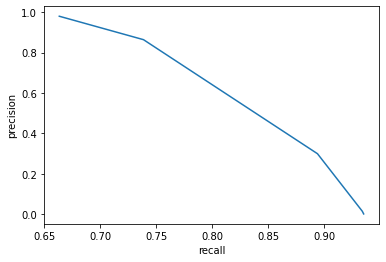

In [ ]:
plt.xlabel('recall')
plt.ylabel('precision')
print(recall)
plt.plot(precision,recall)
plt.show

In [ ]:
test_predictions.select("customer_id", "beer_id", "rewiew", "prediction").show(5)

+-----------+-------+------+----------+
|customer_id|beer_id|rewiew|prediction|
+-----------+-------+------+----------+
|    18911.0|  56973|   4.0|  4.507805|
|    10206.0|   2479|   3.0| 4.0792723|
|     5156.0|    142|   5.0|  4.827548|
|     5156.0|    582|   5.0|  4.525479|
|     5156.0|   1904|   4.0|   5.00798|
+-----------+-------+------+----------+
only showing top 5 rows



# Single value decomposition

Singular Value Decomposition (SVD) is based on a well known matrix factorization method which takes an m × n matrix A, and decomposes it as follows A = UsV. In collaborative filtering U e V raprensent Users and Items. And the Rij is also given by Inner product. S , called the singular matrix, is an m ×ndiagonal matrix whose diagonal entries are non-negative real number. Singular-Value Decomposition is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

Difference with ALS and SVD
ALS iteratively alternate between optimizing U and fixing V and vice versa. It is an iterative optimization process where we for every iteration try to arrive closer and closer to a factorized representation of our original data.

Singular-Value Decomposition is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

The SVD has some problems. It is not scalable and it suffer of missing values (sparcity). With the amount of data volume today, performance quickly degrades. ALS allow to Train a machine learning model on several machines, creating a network or cluster of machines: distributed computing.

In [ ]:
#import surprise and SVD to build the model
!pip install Surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
reader = Reader()
#full_data = full_data.toPandas()
#data = Dataset.load_from_df(full_data[['customer_id', 'beer_id', 'rewiew']], reader)

In [ ]:
full_data = full_data.toPandas()
data = Dataset.load_from_df(full_data[['customer_id', 'beer_id', 'rewiew']], reader)

## Cross Validation RMSE, MAE
K-fold cross-validation uses the following approach to evaluate a model:

* Step 1: Randomly divide a dataset into k groups, or “folds”, of roughly equal size.

* Choose one of the folds to be the holdout set. Fit the model on the remaining k-1 folds. Calculate the test RMSE-MSE on the observations in the fold that was held out. Repeat this process *K-time*.
* Calculate the overall test RMSE-MSE to be the average of the k test RMSE’s.

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.6090  0.6101  0.6074  0.6063  0.6095  0.6085  0.0014  
MAE (testset)     0.4556  0.4568  0.4544  0.4539  0.4562  0.4554  0.0011  
Fit time          87.76   87.94   88.55   86.64   87.70   87.72   0.62    
Test time         3.08    4.35    5.10    4.77    5.06    4.47    0.75    


{'fit_time': (87.76135993003845,
  87.93991732597351,
  88.55086994171143,
  86.64366674423218,
  87.69571805000305),
 'test_mae': array([0.45559796, 0.45677462, 0.45444505, 0.45391772, 0.45623413]),
 'test_rmse': array([0.60901121, 0.61007716, 0.6073766 , 0.60627519, 0.6095455 ]),
 'test_time': (3.0806379318237305,
  4.354472398757935,
  5.09991455078125,
  4.773253679275513,
  5.057433605194092)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

## predictions

In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.8123312451304496, details={'was_impossible': False})

For BeerId with ID 1250 , we get an estimated prediction of 3.85. One startling feature of this recommender system is that it doesn't care what the beer is (or what it contains). It works purely on the basis of an assigned beerID and tries to predict ratings based on how the other costumers have predicted the beers.

##Bibliography
[Getting Started With Movie Recommendetions](https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system)


[MF_RecommenderSystem](https://colab.research.google.com/drive/1hRCowP1bNn4pOkxMtGoptTBLLf6TH9uh)